In [16]:
# %% Cell 1 — Imports & Config
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.io as sio
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import time

# ========== Configuration ==========
BASE = Path(r"E:\DeepVision Crowd Monitor Ai\Dataset\ShanghaiTech")
PART_A = BASE / "part_A"
PART_B = BASE / "part_B"

TRAIN_IMG_DIR_A = PART_A / "train_data" / "images"
TRAIN_GT_DIR_A  = PART_A / "train_data" / "ground-truth"
TEST_IMG_DIR_A  = PART_A / "test_data" / "images"
TEST_GT_DIR_A   = PART_A / "test_data" / "ground-truth"

TRAIN_IMG_DIR_B = PART_B / "train_data" / "images"
TRAIN_GT_DIR_B  = PART_B / "train_data" / "ground-truth"
TEST_IMG_DIR_B  = PART_B / "test_data" / "images"
TEST_GT_DIR_B   = PART_B / "test_data" / "ground-truth"

OUTPUT_DIR = BASE / "preprocessed"
DENSITY_OUT_TRAIN = OUTPUT_DIR / "density_maps" / "train"
DENSITY_OUT_TEST  = OUTPUT_DIR / "density_maps" / "test"
DENSITY_OUT_TRAIN.mkdir(parents=True, exist_ok=True)
DENSITY_OUT_TEST.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Sizes (fixed input size for batching)
IMG_H, IMG_W = 512, 768           # resize all images to 512x768
DS_FACTOR = 8                     # downsample factor for CSRNet (output H/8 x W/8)
DENS_H = IMG_H // DS_FACTOR
DENS_W = IMG_W // DS_FACTOR

BATCH_SIZE = 8
NUM_WORKERS = 0  # Windows/Jupyter safe
LEARNING_RATE = 1e-5
EPOCHS = 2       # set low for quick runs; increase for real training
CHECKPOINT_DIR = BASE / "checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

print("Image size:", IMG_H, IMG_W, "Density size:", DENS_H, DENS_W)


Device: cpu
Image size: 512 768 Density size: 64 96


In [17]:
# %% Cell 2 — Helper functions: load .mat points robustly and build adaptive density maps

def _find_points_in_mat(mat):
    """Return the largest candidate (N,2) numeric array from matlab dict."""
    candidates = []
    def recurse(obj):
        if isinstance(obj, np.ndarray):
            if obj.ndim == 2 and obj.shape[1] == 2 and np.issubdtype(obj.dtype, np.number):
                candidates.append(obj.astype(np.float32))
            if obj.ndim >= 2 and obj.shape[-1] == 2 and np.issubdtype(obj.dtype, np.number):
                try:
                    flat = obj.reshape(-1, 2)
                    if flat.shape[0] > 0:
                        candidates.append(flat.astype(np.float32))
                except Exception:
                    pass
            if obj.dtype == object:
                for item in obj.flatten():
                    recurse(item)
        elif isinstance(obj, dict):
            for v in obj.values():
                recurse(v)
        elif isinstance(obj, (list, tuple)):
            for v in obj:
                recurse(v)
    recurse(mat)
    if len(candidates) == 0:
        return np.zeros((0,2), dtype=np.float32)
    candidates.sort(key=lambda x: x.shape[0], reverse=True)
    return candidates[0]

def load_gt_mat(path):
    mat = sio.loadmat(str(path))
    pts = _find_points_in_mat(mat)
    return pts  # shape (N,2) or empty

def points_to_density_adaptive(img_shape, points, k=3, adaptive_ratio=0.3, fixed_sigma=None):
    H, W = img_shape
    density = np.zeros((H, W), dtype=np.float32)
    if points.size == 0:
        return density
    pts = points.copy()
    if pts.ndim == 1:
        pts = pts.reshape(1, -1)
    good = []
    for p in pts:
        x, y = float(p[0]), float(p[1])
        if np.isfinite(x) and np.isfinite(y):
            ix = int(round(y)); iy = int(round(x))
            if 0 <= ix < H and 0 <= iy < W:
                good.append([x,y])
    if len(good) == 0:
        return density
    pts = np.array(good, dtype=np.float32)
    N = pts.shape[0]
    if fixed_sigma is None:
        if N > 1:
            nbrs = NearestNeighbors(n_neighbors=min(k+1, N)).fit(pts)
            distances, _ = nbrs.kneighbors(pts)
            avg_dist = np.mean(distances[:, 1:min(k+1, distances.shape[1])], axis=1)
            sigmas = avg_dist * adaptive_ratio
            sigmas[sigmas <= 0] = 1.0
        else:
            sigmas = np.array([15.0])
    else:
        sigmas = np.ones((N,), dtype=np.float32) * float(fixed_sigma)
    for (x,y), sigma in zip(pts, sigmas):
        sigma = max(sigma, 1.0)
        radius = int(3 * sigma)
        x_min = max(0, int(round(x)) - radius)
        x_max = min(W-1, int(round(x)) + radius)
        y_min = max(0, int(round(y)) - radius)
        y_max = min(H-1, int(round(y)) + radius)
        xs = np.arange(x_min, x_max+1)
        ys = np.arange(y_min, y_max+1)
        if xs.size == 0 or ys.size == 0:
            continue
        xv, yv = np.meshgrid(xs, ys)
        gaussian = np.exp(-((xv - x)**2 + (yv - y)**2) / (2 * sigma * sigma))
        gaussian = gaussian / (2 * np.pi * sigma * sigma)
        density[y_min:y_max+1, x_min:x_max+1] += gaussian.astype(np.float32)
    s = density.sum()
    if s > 0:
        density = density * (float(N) / s)
    return density

def resize_density_with_pil(density, new_h, new_w):
    """Resize float64/float32 density map using PIL bicubic and return float32.
       After resizing, scale by factor^2 to preserve counts if shrinking.
    """
    from PIL import Image
    H, W = density.shape
    img = Image.fromarray(density.astype(np.float32), mode='F')
    img_resized = img.resize((new_w, new_h), resample=Image.BICUBIC)
    arr = np.array(img_resized).astype(np.float32)
    # scale factor: preserve total counts
    scale = (H * W) / (new_h * new_w) if (new_h*new_w)>0 else 1.0
    # alternative: multiply by (orig_area / new_area) but since we want to preserve sum we use:
    arr *= scale
    return arr

In [18]:
# %% Cell 3 — Preprocessing loop (Part A train & test, Part B optional)
# For each image: find GT mat, create full-size density, downsample by DS_FACTOR using PIL bicubic,
# multiply appropriately to preserve counts and save as .npy in DENSITY_OUT_TRAIN / DENSITY_OUT_TEST.

def preprocess_folder(img_dir, gt_dir, out_dir, img_h=IMG_H, img_w=IMG_W, ds_factor=DS_FACTOR):
    img_dir = Path(img_dir)
    gt_dir = Path(gt_dir)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    img_paths = sorted(list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.png")))
    print(f"Found {len(img_paths)} images in {img_dir}")
    for img_path in tqdm(img_paths):
        stem = img_path.stem
        # possible GT filenames in ShanghaiTech: GT_*.mat or *.mat
        candidates = [gt_dir / f"GT_{stem}.mat", gt_dir / f"{stem}.mat"]
        gt_path = None
        for c in candidates:
            if c.exists():
                gt_path = c
                break
        if gt_path is None:
            # skip and continue
            # print("GT not found for", img_path.name)
            continue
        # load image to know original dims
        img = Image.open(img_path).convert("RGB")
        orig_w, orig_h = img.size
        # load points and build density at original resolution
        pts = load_gt_mat(gt_path)
        density_full = points_to_density_adaptive((orig_h, orig_w), pts)
        # ensure full-sum equals points
        # Now resize image to fixed IMG_H x IMG_W and density accordingly
        img_resized = img.resize((img_w, img_h), resample=Image.BICUBIC)
        # Resize density_full to IMG_H x IMG_W preserving count (we use resize_density_with_pil)
        density_resized_full = resize_density_with_pil(density_full, img_h, img_w)
        # Now downsample density to H/DS x W/DS
        new_h = img_h // ds_factor
        new_w = img_w // ds_factor
        density_ds = resize_density_with_pil(density_resized_full, new_h, new_w)
        # Save downsampled density .npy
        out_file = out_dir / f"{stem}.npy"
        np.save(out_file, density_ds.astype(np.float32))
    print("Preprocessing finished for", img_dir)

# Run preprocessing for Part A train & test
preprocess_folder(TRAIN_IMG_DIR_A, TRAIN_GT_DIR_A, DENSITY_OUT_TRAIN)
preprocess_folder(TEST_IMG_DIR_A, TEST_GT_DIR_A, DENSITY_OUT_TEST)

# (Optional) uncomment to preprocess Part B as well:
preprocess_folder(TRAIN_IMG_DIR_B, TRAIN_GT_DIR_B, DENSITY_OUT_TRAIN)
preprocess_folder(TEST_IMG_DIR_B, TEST_GT_DIR_B, DENSITY_OUT_TEST)

Found 300 images in E:\DeepVision Crowd Monitor Ai\Dataset\ShanghaiTech\part_A\train_data\images


100%|██████████| 300/300 [00:12<00:00, 23.23it/s]


Preprocessing finished for E:\DeepVision Crowd Monitor Ai\Dataset\ShanghaiTech\part_A\train_data\images
Found 182 images in E:\DeepVision Crowd Monitor Ai\Dataset\ShanghaiTech\part_A\test_data\images


100%|██████████| 182/182 [00:07<00:00, 24.73it/s]


Preprocessing finished for E:\DeepVision Crowd Monitor Ai\Dataset\ShanghaiTech\part_A\test_data\images
Found 400 images in E:\DeepVision Crowd Monitor Ai\Dataset\ShanghaiTech\part_B\train_data\images


100%|██████████| 400/400 [00:18<00:00, 21.95it/s]


Preprocessing finished for E:\DeepVision Crowd Monitor Ai\Dataset\ShanghaiTech\part_B\train_data\images
Found 316 images in E:\DeepVision Crowd Monitor Ai\Dataset\ShanghaiTech\part_B\test_data\images


100%|██████████| 316/316 [00:14<00:00, 22.22it/s]

Preprocessing finished for E:\DeepVision Crowd Monitor Ai\Dataset\ShanghaiTech\part_B\test_data\images


In [19]:
def generate_density_map(points, w, h, sigma=4):
    density = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density

    for p in points:
        x, y = int(p[0]), int(p[1])
        if x >= w or y >= h or x < 0 or y < 0:
            continue
        density[y, x] += 1

    density = gaussian_filter(density, sigma, mode="constant")
    return density

In [21]:
def generate_density_map(points, w, h, sigma=4):
    density = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density

    for p in points:
        x, y = int(p[0]), int(p[1])
        if x >= w or y >= h or x < 0 or y < 0:
            continue
        density[y, x] += 1

    density = gaussian_filter(density, sigma, mode="constant")
    return density


In [22]:
import os
from pathlib import Path
import numpy as np
import glob
import scipy.io
from PIL import Image
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

train_images = sorted(glob.glob(str(TRAIN_IMG_DIR_A / "*.jpg")))
DOWNSAMPLE = 8      # CSRNet requirement (VGG reduces by 8×)

for img_path in train_images:
    img = Image.open(img_path).convert("RGB")
    orig_w, orig_h = img.size

    # Resize image
    img_resized = img.resize((IMG_W, IMG_H))

    # Load GT MAT
    stem = Path(img_path).stem
    mat_path = TRAIN_GT_DIR_A / f"GT_{stem}.mat"
    mat = scipy.io.loadmat(mat_path)

    # Correct way to extract points
    pts = mat["image_info"][0, 0][0, 0][0]  

    # SCALE points to new image size
    pts_scaled = []
    for p in pts:
        x = p[0] * (IMG_W / orig_w)
        y = p[1] * (IMG_H / orig_h)
        pts_scaled.append([x, y])

    pts_scaled = np.array(pts_scaled)

    # Generate density map
    dens = generate_density_map(pts_scaled, IMG_W, IMG_H, sigma=4)

    # Downsample
    dens_ds = cv2.resize(
        dens,
        (IMG_W//DOWNSAMPLE, IMG_H//DOWNSAMPLE),
        interpolation=cv2.INTER_CUBIC
    )

    # Multiply by 64
    dens_ds *= (DOWNSAMPLE * DOWNSAMPLE)

    # Save
    np.save(str(DENSITY_OUT_TRAIN / f"{stem}.npy"), dens_ds)


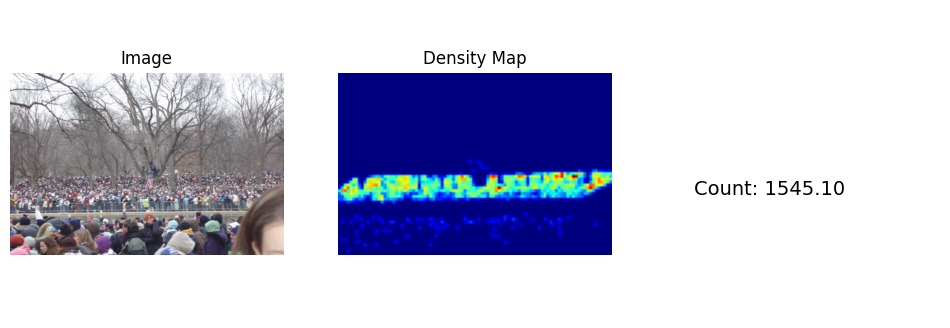

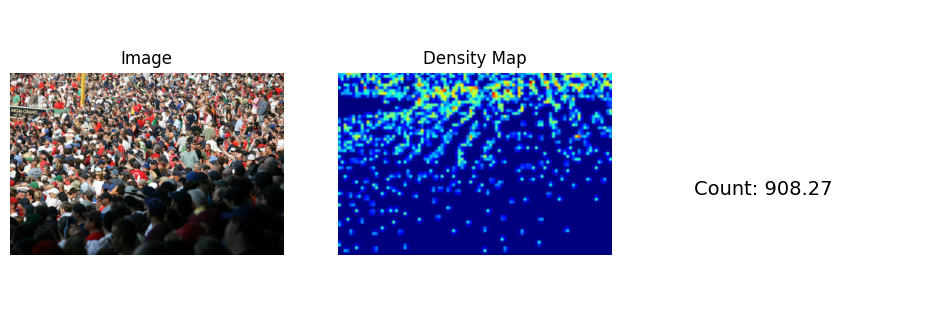

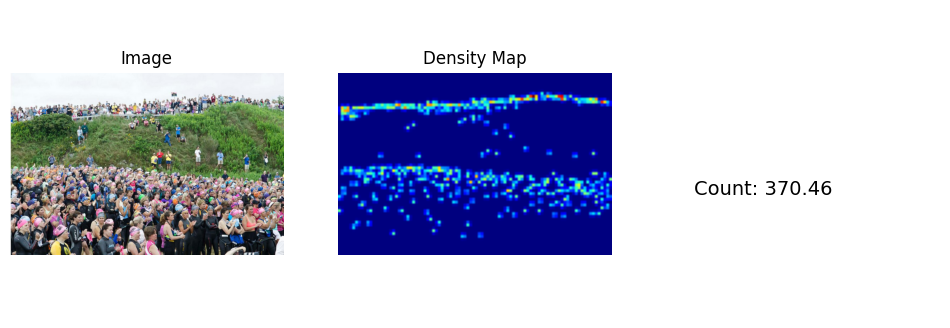

In [23]:
from matplotlib import cm

sample_files = list(TRAIN_IMG_DIR_A.glob("*.jpg"))[:3]

for img_path in sample_files:
    stem = img_path.stem
    dens_path = DENSITY_OUT_TRAIN / f"{stem}.npy"
    if not dens_path.exists():
        continue

    img = Image.open(img_path).convert("RGB").resize((IMG_W, IMG_H))
    dens = np.load(str(dens_path))

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(dens, cmap="jet"); plt.title("Density Map"); plt.axis("off")
    plt.subplot(1,3,3); plt.text(0.1, 0.4, f"Count: {dens.sum():.2f}", fontsize=14); plt.axis("off")
    plt.show()


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ImageNet normalization (mandatory for CSRNet / VGG16)
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class CrowdDataset(Dataset):
    def __init__(self, img_dir, dens_dir, transform=None):
        self.img_paths = sorted(list(img_dir.glob("*.jpg")))
        self.dens_dir = dens_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        stem = img_path.stem

        # Load & process image
        img = Image.open(img_path).convert("RGB")
        img = img.resize((IMG_W, IMG_H))
        if self.transform:
            img = self.transform(img)

        # Load density map
        dens_path = self.dens_dir / f"{stem}.npy"
        dens = np.load(str(dens_path)).astype(np.float32)
        dens = torch.from_numpy(dens).unsqueeze(0)

        return img, dens


In [25]:
print("Images A:", len(list(TRAIN_IMG_DIR_A.glob("*.jpg"))))
print("GT A:", len(list(TRAIN_GT_DIR_A.glob("*.mat"))))
print("Density Train:", len(list(DENSITY_OUT_TRAIN.glob("*.npy"))))


Images A: 300
GT A: 300
Density Train: 400


In [26]:
train_dataset = CrowdDataset(TRAIN_IMG_DIR_A, DENSITY_OUT_TRAIN, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [27]:
for imgs, dens in train_loader:
    print(imgs.shape, dens.shape)
    break


torch.Size([4, 3, 512, 768]) torch.Size([4, 1, 64, 96])


In [28]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        # VGG-16 Front end
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])

        # Dilated convolution backend
        self.backend = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

In [29]:
import torch

# Select GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load CSRNet model
model = CSRNet().to(device)

Using device: cpu


e:\DeepVision Crowd Monitor Ai\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\DeepVision Crowd Monitor Ai\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\kumar/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [15:52<00:00, 581kB/s]   


In [30]:
model = CSRNet().to(device)

In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)